In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plorts
from common import *
from IPython.display import clear_output
# import PIL
plt.style.use(['plorts', 'plorts-print', './buffer-workshop.mplstyle'])
width = 7.141/3
matplotlib.rcParams['figure.figsize'] = (width, width*1/3)

In [3]:
df = pd.read_sql("""
select * from experiments
where note in ('postcard', 'postcard-ecn', 'postcard-20000')
and algorithm in ('reno', 'bbr', 'scalable', 'cubic')
and action = 'drop'
""", con=con)
print( list(df.columns) )

['index', 'action', 'algorithm', 'filename', 'id', 'max_queue_depth_bytes', 'max_queue_depth_cells', 'max_queue_depth_packets', 'mtu_bytes', 'num_flows', 'receiver_delay', 'note', 'run_at', 'pacing', 'pacing_factor', 'experimenter']


In [4]:
n_exp = len(pd.unique(df.id))
print("There are {} experiments in scope".format(n_exp))

There are 184 experiments in scope


In [5]:
assert len(pd.unique(df.mtu_bytes)) == 1
mtu = pd.unique(df.mtu_bytes)[0]

rtt = 0.0012 # 1.2 msec

bdp = 10e9 * rtt / 8 / mtu #BDP in packets
print("BDP = {} packets".format(bdp))

BDP = 166.66666666666663 packets


In [7]:
data = []
k = 3
i = 0
tail = 0.05

for (buff_size,num_flows,algo,action,exp_id),exp_df in df.groupby(['max_queue_depth_packets', 'num_flows', 'algorithm', 'action', 'id']):
        
    buff_size = np.ceil(buff_size)
    algo = algo.title()
    
    fair_win_l = bdp / num_flows
    fair_win_r = (bdp) / num_flows
    
    tr_df = pd.read_sql("""
        select timestamp_sec, snd_cwnd, sport, dport from traces
        where experiment_id = '%s'
        and sport != 22 and dport != 22
        """%(exp_id),con=con)
    
    # Only consider middle (k-2)/k-th of the experiment duration for inefficiency
    ts_min = tr_df['timestamp_sec'].min()
    ts_max = tr_df['timestamp_sec'].max()
    ts_dif = ts_max - ts_min
    ts_min += ts_dif / k
    ts_max -= ts_dif / k
    ts_dur = ts_max - ts_min
    
    tr_df = tr_df[(tr_df.timestamp_sec > ts_min) & (tr_df.timestamp_sec < ts_max)]
    
    # Calculate the absolute delta (smallest/largest) within an experiment
    abs_delta_l = fair_win_l / tr_df.snd_cwnd.min()
    abs_delta_l_tail = fair_win_l / tr_df.snd_cwnd.quantile(tail/2)
    abs_delta_r = tr_df.snd_cwnd.max() / fair_win_r
    abs_delta_r_tail = tr_df.snd_cwnd.quantile(1-tail) / fair_win_r
    
    delta_ls = []
    delta_ls_tail = []
    delta_rs = []
    delta_rs_tail = []
    for (sport,dport),fdf in tr_df.groupby(['sport','dport']):
        delta_ls.append(fair_win_l / fdf.snd_cwnd.min())
        delta_ls_tail.append(fair_win_l / fdf.snd_cwnd.quantile(tail))
        delta_rs.append(fdf.snd_cwnd.max() / fair_win_r)
        delta_rs_tail.append(fdf.snd_cwnd.quantile(1-tail/2) / fair_win_r)
    # Calculate average delta among different flows within the same experiment
    ave_delta_l = sum(delta_ls) / len(delta_ls)
    ave_delta_l_tail = sum(delta_ls_tail) / len(delta_ls_tail)
    ave_delta_r = sum(delta_rs) / len(delta_rs) 
    ave_delta_r_tail = sum(delta_rs_tail) / len(delta_rs_tail)
    
    data.append([algo, num_flows, buff_size, 
                 abs_delta_l, abs_delta_l_tail,
                 abs_delta_r, abs_delta_r_tail,
                 ave_delta_l, ave_delta_l_tail,
                 ave_delta_r, ave_delta_r_tail])
    
    i += 1
    clear_output(wait=True)
    print("{}/{} completed.".format(i,n_exp))

deltas_df = pd.DataFrame(data, columns = ['algorithm', 'num_flows', 'buff_size', 
                                          'abs_delta_l', 'abs_delta_l_tail',
                                          'abs_delta_r', 'abs_delta_r_tail',
                                          'ave_delta_l', 'ave_delta_l_tail',
                                          'ave_delta_r', 'ave_delta_r_tail'])
deltas_df

184/184 completed.


,algorithm,num_flows,buff_size,abs_delta_l,abs_delta_l_tail,abs_delta_r,abs_delta_r_tail,ave_delta_l,ave_delta_l_tail,ave_delta_r,ave_delta_r_tail
0,Bbr,1,9.0,1.157407,0.974659,2.136,2.112,1.157407,0.952381,2.136000,2.124000
1,Cubic,1,9.0,4.273504,4.166667,0.570,0.492,4.273504,4.166667,0.570000,0.492000
2,Reno,1,9.0,11.904762,7.936508,0.474,0.438,11.904762,6.666667,0.474000,0.456000
3,Scalable,1,9.0,3.401361,3.086420,0.462,0.438,3.401361,2.976190,0.462000,0.450000
4,Bbr,2,9.0,1.322751,0.750751,2.832,2.784,1.188802,0.528782,2.712000,2.688000
...,...,...,...,...,...,...,...,...,...,...,...
179,Reno,8,223.0,1.488095,0.905797,4.080,3.744,1.057364,0.821924,3.600000,3.504000
180,Reno,16,223.0,2.083333,1.041667,6.144,4.512,1.322477,0.888543,4.398000,4.200000
181,Reno,32,223.0,2.604167,1.041667,6.336,4.800,1.603190,0.919862,5.094000,4.801500
182,Reno,64,223.0,2.604167,1.302083,11.136,5.760,2.197266,0.956217,6.708000,6.155850


In [8]:
deltas_df['formatted_algorithm'] = ['BBR' if a == 'Bbr' else a for a in deltas_df['algorithm']]
deltas_df['abs_delta_inv'] = 1/deltas_df['abs_delta_l_tail']
deltas_df.head()

,algorithm,num_flows,buff_size,abs_delta_l,abs_delta_l_tail,abs_delta_r,abs_delta_r_tail,ave_delta_l,ave_delta_l_tail,ave_delta_r,ave_delta_r_tail,formatted_algorithm,abs_delta_inv
0,Bbr,1,9.0,1.157407,0.974659,2.136,2.112,1.157407,0.952381,2.136,2.124,BBR,1.026
1,Cubic,1,9.0,4.273504,4.166667,0.570,0.492,4.273504,4.166667,0.570,0.492,Cubic,0.240
2,Reno,1,9.0,11.904762,7.936508,0.474,0.438,11.904762,6.666667,0.474,0.456,Reno,0.126
3,Scalable,1,9.0,3.401361,3.086420,0.462,0.438,3.401361,2.976190,0.462,0.450,Scalable,0.324
4,Bbr,2,9.0,1.322751,0.750751,2.832,2.784,1.188802,0.528782,2.712,2.688,BBR,1.332


In [12]:
deltas_df.to_csv('./calculated_deltas.csv')

In [13]:
deltas_df = pd.read_csv('./calculated_deltas.csv')

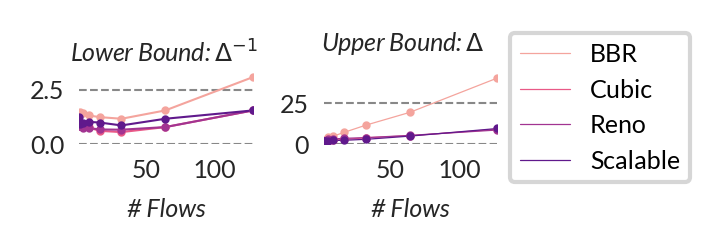

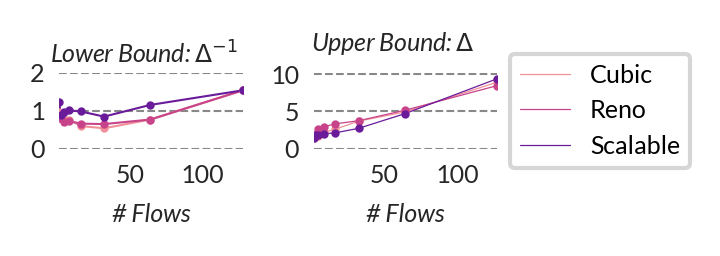

In [20]:
buf_df = deltas_df.groupby(['num_flows', 'formatted_algorithm'], as_index=False).agg({
    'abs_delta_inv': 'mean',
    'abs_delta_r': 'mean',
    'abs_delta_r_tail': 'mean'
})

for buff_size, buf_df in [('all', buf_df), ('no_bbr', buf_df[buf_df.formatted_algorithm != 'BBR'])]:
    #if len(pd.unique(buf_df.algorithm)) == 1:
    #    continue
    
    plt.figure(figsize=(width, width*1/3))
    
    plt.subplot(1,2,1)
    plorts.plot(data=buf_df, x='num_flows', y='abs_delta_inv', hue='formatted_algorithm', linewidth=0.5)
    plorts.scatter(data=buf_df, x='num_flows', y='abs_delta_inv', hue='formatted_algorithm', markersize=1)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel(r"Lower Bound: $\Delta^{-1}$")
    plt.xlabel("# Flows")
    #plt.yscale('log')
    plt.axis(ymin=0)#,ymax=25)
    if buff_size == 'no_bbr':
        plt.yticks([0,1,2])
    plorts.style_axis()
    
    plt.subplot(1,2,2)
    plorts.plot(data=buf_df, x='num_flows', y='abs_delta_r_tail', hue='formatted_algorithm', linewidth=0.3)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plorts.legend(loc='end')
    plorts.scatter(data=buf_df, x='num_flows', y='abs_delta_r_tail', hue='formatted_algorithm', markersize=1)
    plt.ylabel(r"Upper Bound: $\Delta$")
    plt.xlabel("# Flows")
    plt.axis(ymin=0)
    if buff_size == 'no_bbr':
        plt.yticks([0,5,10])
    plorts.style_axis()
    
    #plt.suptitle(r"Absolute $\Delta$-almost Fairness for Buffer Size: {}".format(buff_size),
    #             x = 0.45, y = 1)
    
    plt.savefig('../figures/delta_almost_fairness/absoluteFairness_num_flows_{}.jpg'.format(buff_size))
    plt.show()

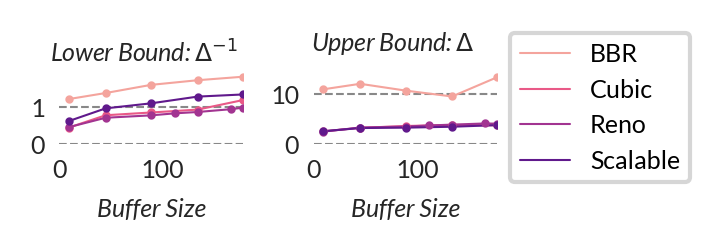

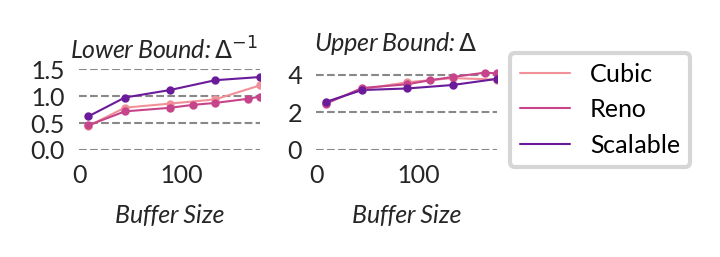

In [23]:
buf_df = deltas_df.groupby(['buff_size', 'formatted_algorithm'], as_index=False).agg({
    'abs_delta_inv': 'mean',
    'abs_delta_r': 'mean',
    'abs_delta_r_tail': 'mean'
})
buf_df = buf_df[buf_df.buff_size < 180]

for buff_size, buf_df in [('all', buf_df), ('no_bbr', buf_df[buf_df.formatted_algorithm != 'BBR'])]:
    #if len(pd.unique(buf_df.algorithm)) == 1:
    #    continue
    
    plt.figure(figsize=(width, width*1/3))
    
    plt.subplot(1,2,1)
    plorts.plot(data=buf_df, x='buff_size', y='abs_delta_inv', hue='formatted_algorithm', linewidth=0.5)
    plorts.scatter(data=buf_df, x='buff_size', y='abs_delta_inv', hue='formatted_algorithm', markersize=1)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel(r"Lower Bound: $\Delta^{-1}$")
    plt.xlabel("Buffer Size")
    #plt.yscale('log')
    plt.axis(ymin=0, xmin=0)#,ymax=25)
    if buff_size == 'no_bbr':
        plt.yticks([0., 0.5, 1, 1.5])
    plorts.style_axis()
    
    plt.subplot(1,2,2)
    plorts.plot(data=buf_df, x='buff_size', y='abs_delta_r_tail', hue='formatted_algorithm', linewidth=0.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plorts.legend(loc='end')
    plorts.scatter(data=buf_df, x='buff_size', y='abs_delta_r_tail', hue='formatted_algorithm', markersize=1)
    plt.ylabel(r"Upper Bound: $\Delta$")
    plt.xlabel("Buffer Size")
    plt.axis(ymin=0, xmin=0)
    if buff_size == 'no_bbr':
        plt.yticks([0,2,4])
    plorts.style_axis()
    
    #plt.suptitle(r"Absolute $\Delta$-almost Fairness for Buffer Size: {}".format(buff_size),
    #             x = 0.45, y = 1)
    
    plt.savefig('../figures/delta_almost_fairness/absoluteFairness_bufferSize_{}.jpg'.format(buff_size))
    plt.show()

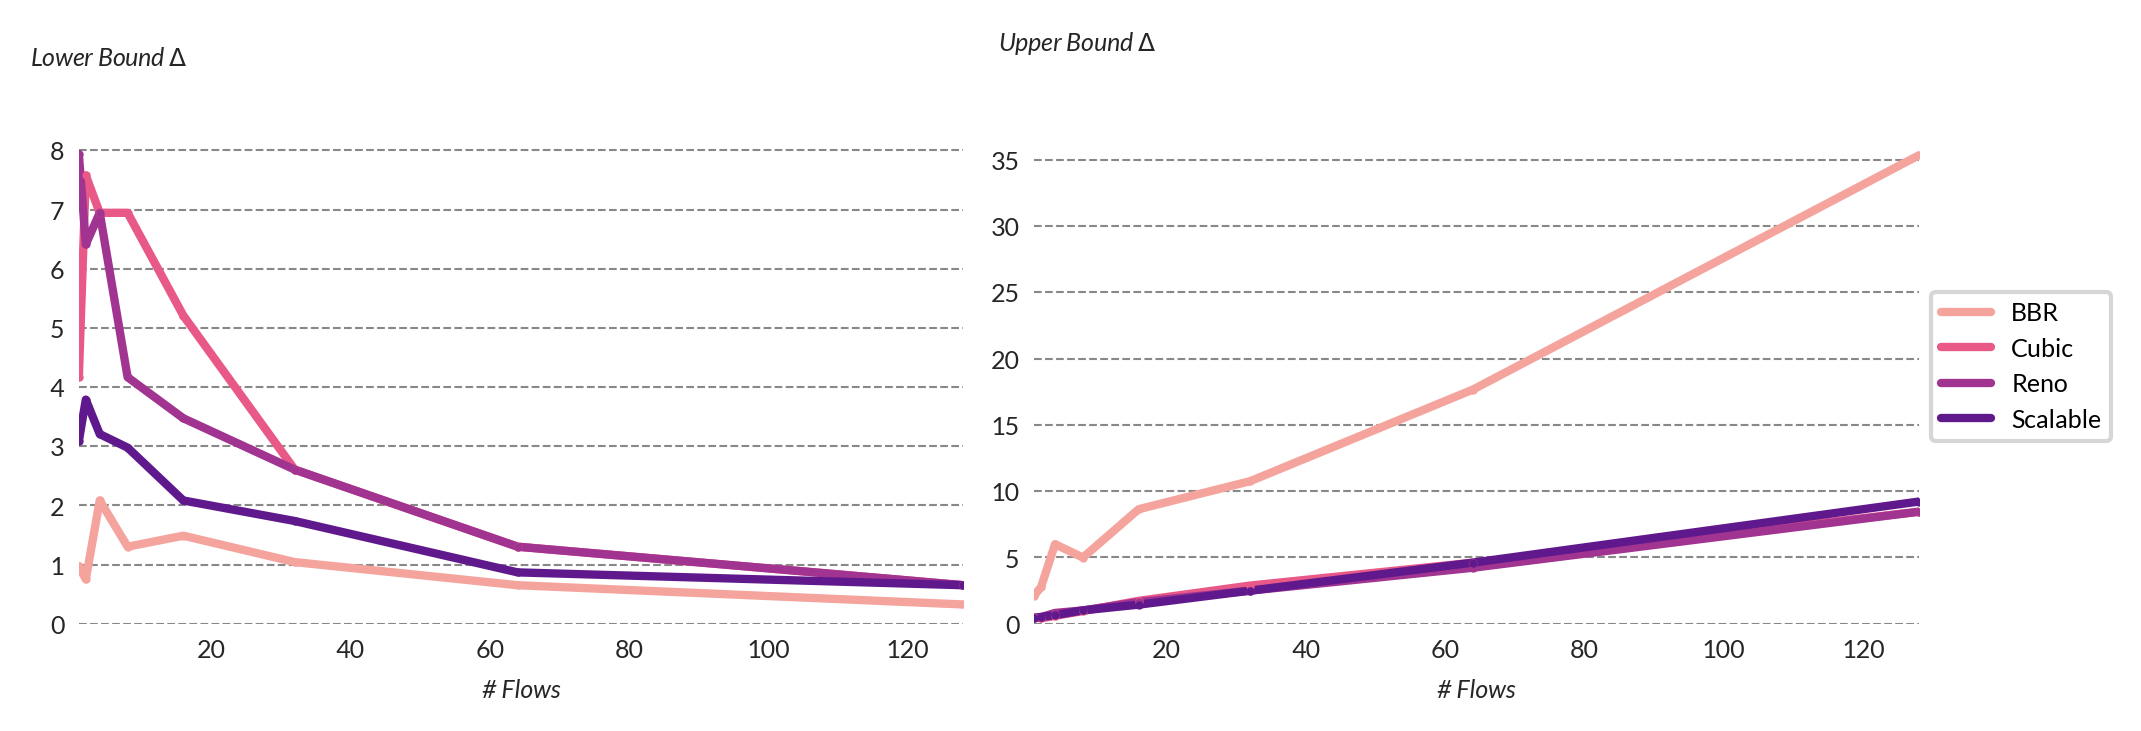

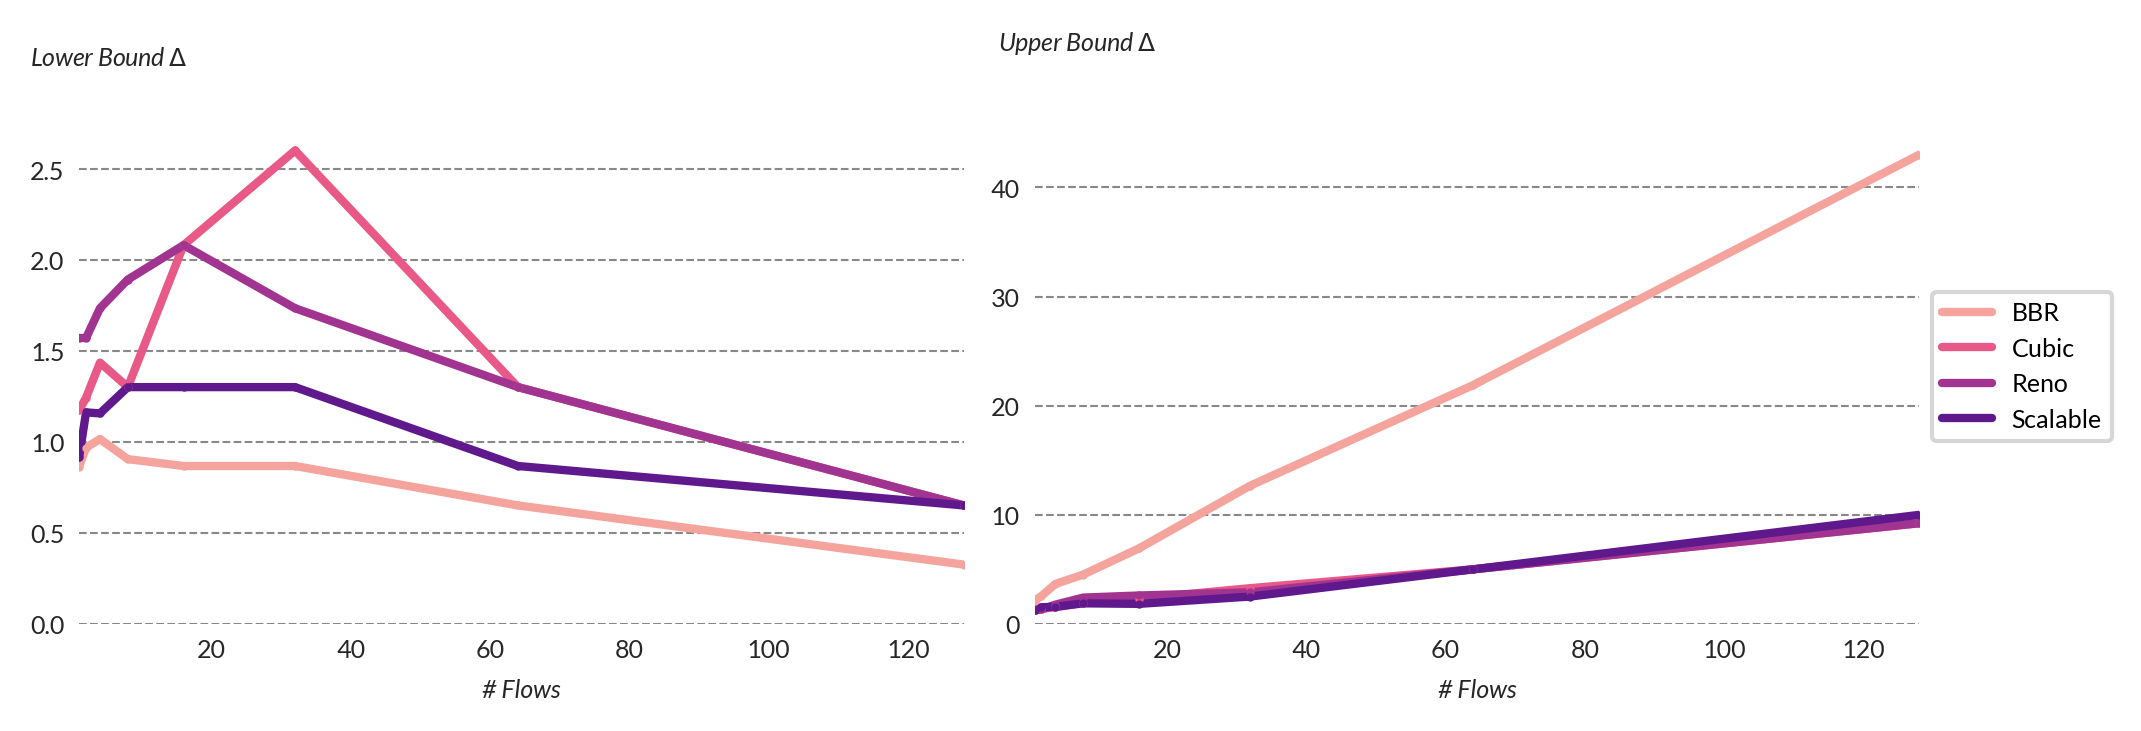

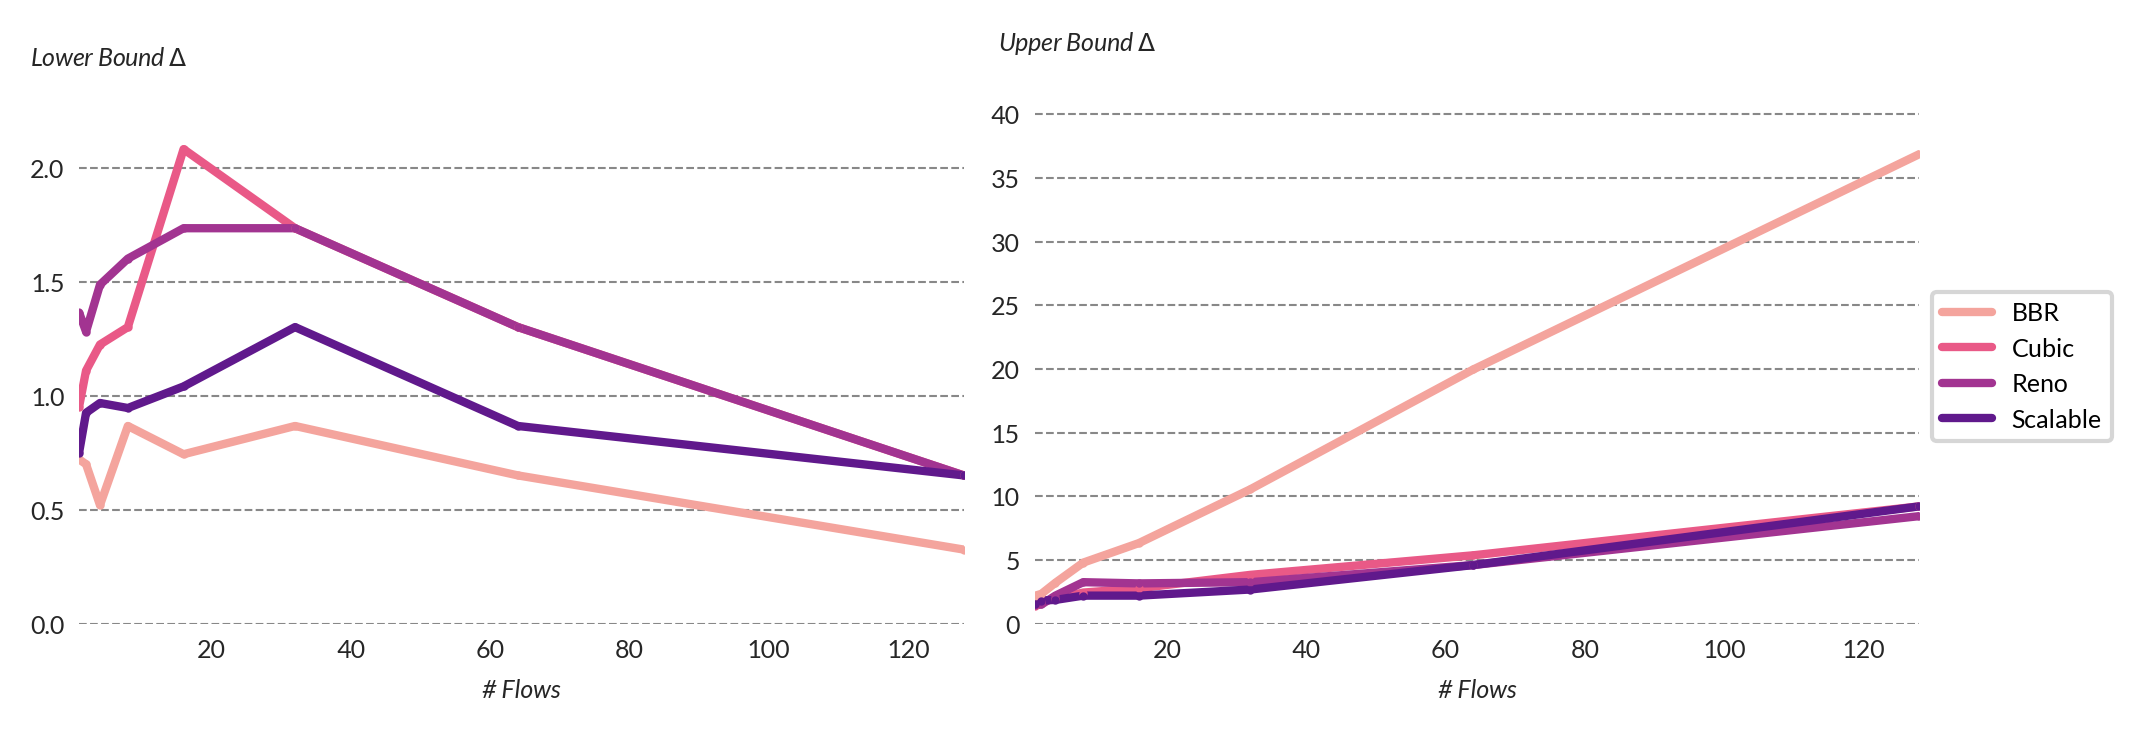

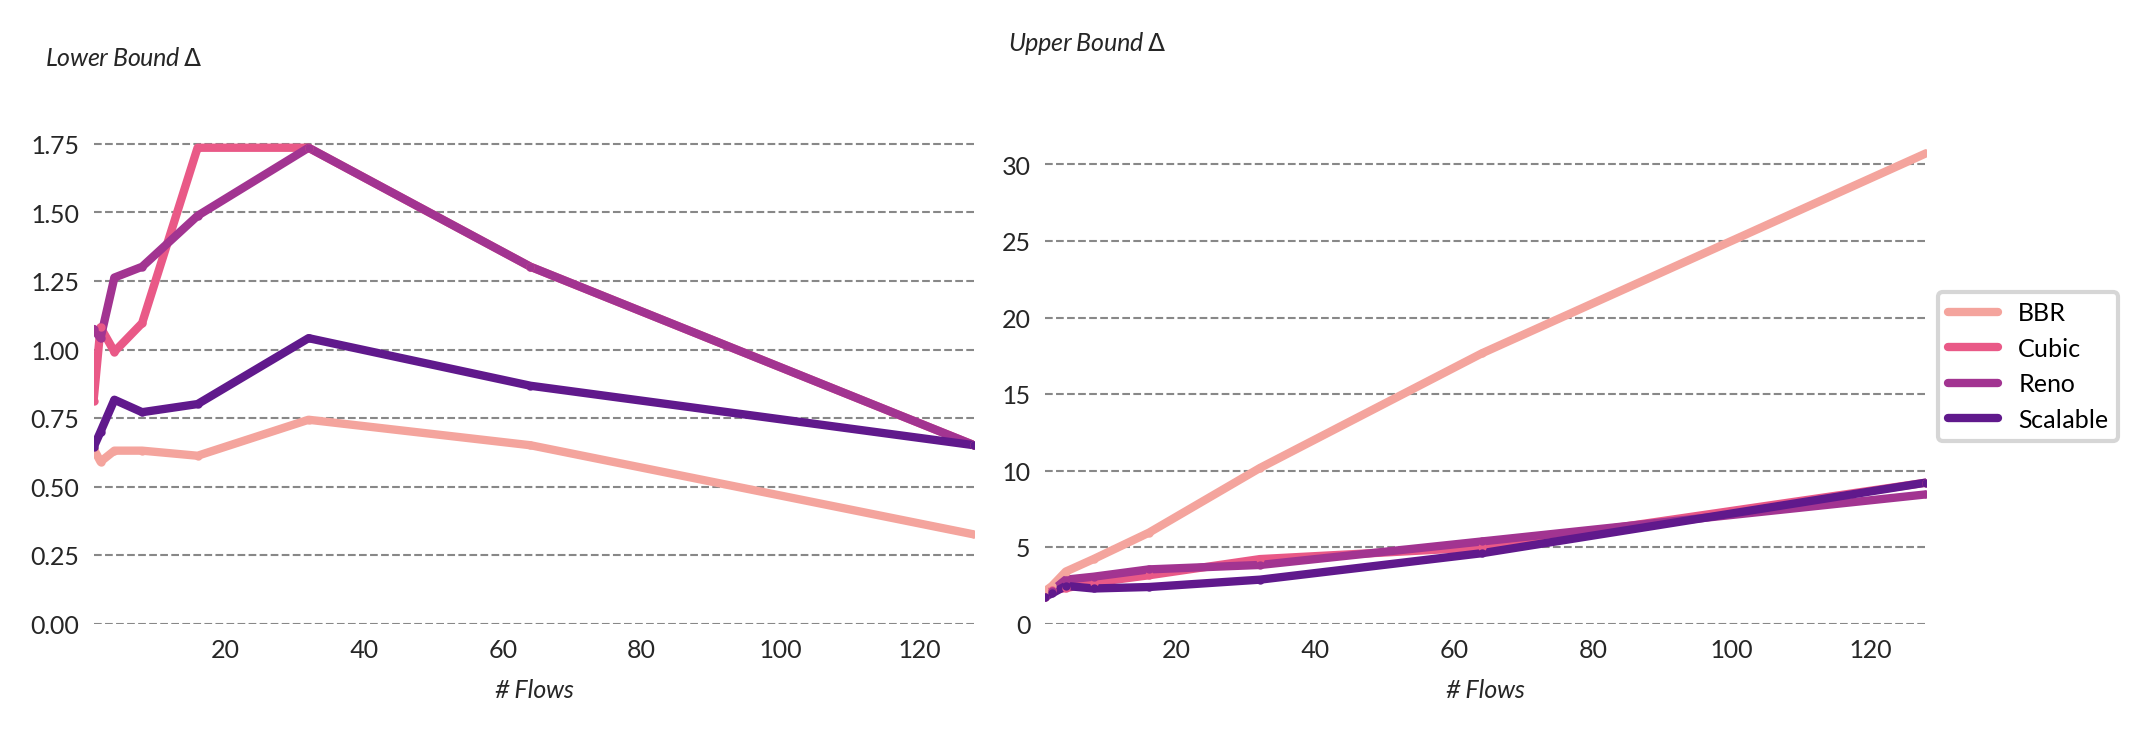

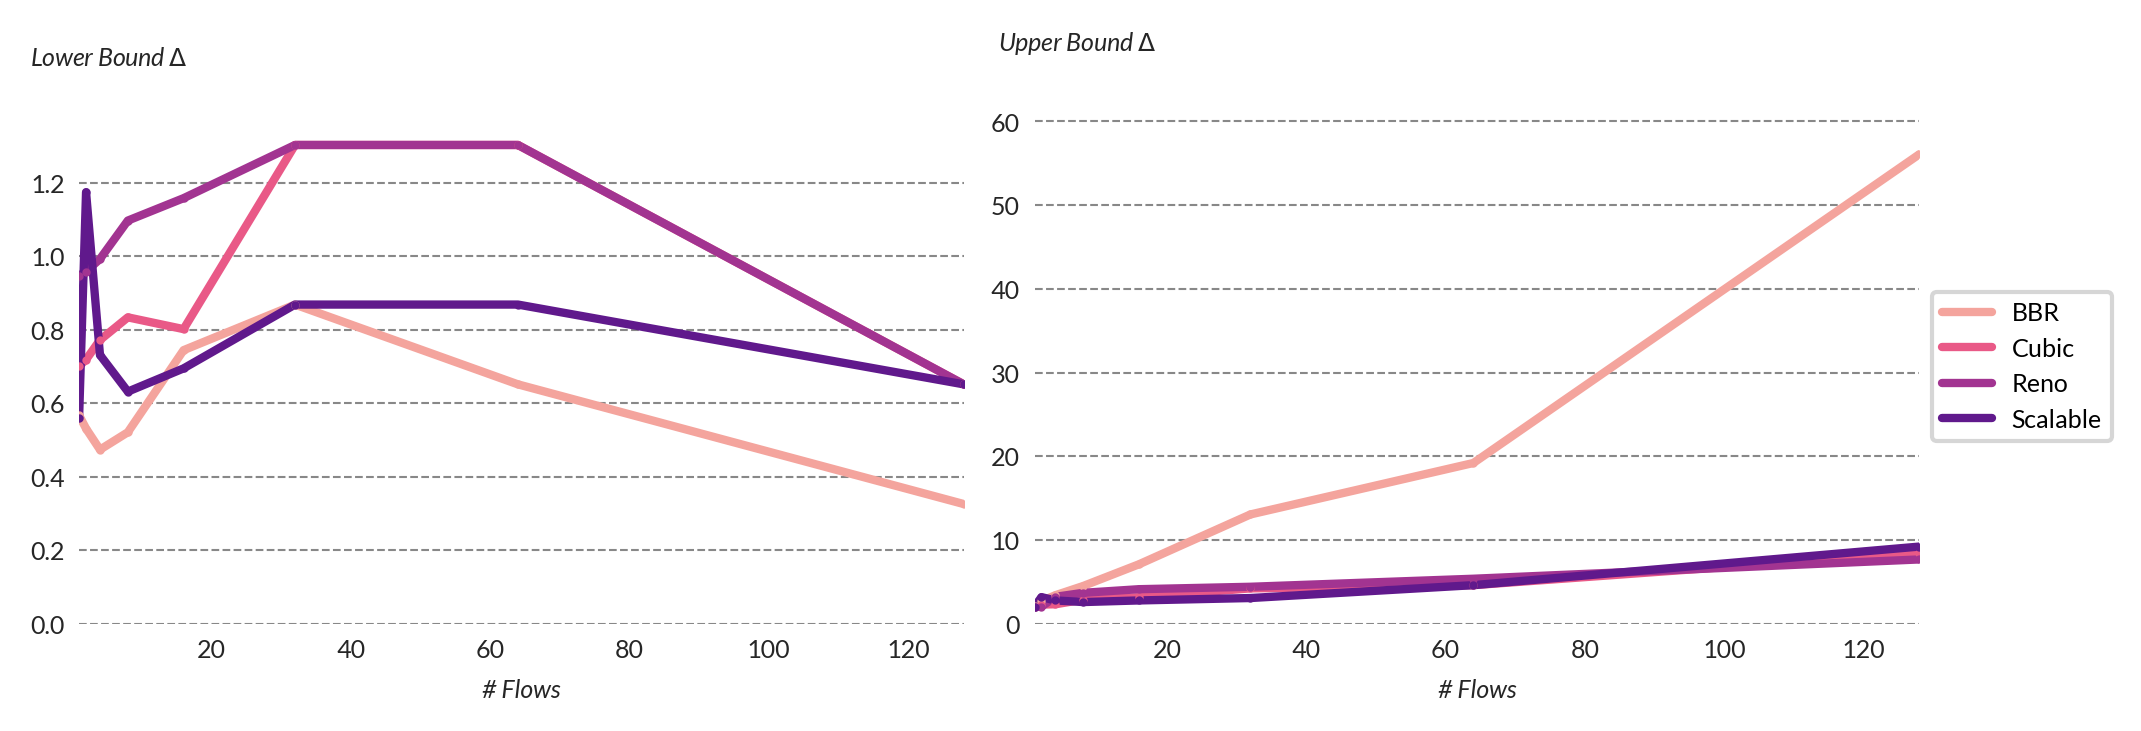

In [11]:
for buff_size, buf_df in deltas_df.groupby(['buff_size']):
    if len(pd.unique(buf_df.algorithm)) == 1:
        continue
    
    plt.figure(figsize=(width, width*1/3))
    
    plt.subplot(1,2,1)
    plorts.plot(data=buf_df, x='num_flows', y='abs_delta_l_tail', hue='formatted_algorithm')
    plorts.scatter(data=buf_df, x='num_flows', y='abs_delta_l_tail', hue='formatted_algorithm', markersize=1)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel(r"Lower Bound $\Delta$")
    plt.xlabel("# Flows")
    plt.axis(ymin=0)#,ymax=8)
    plorts.style_axis()
    
    plt.subplot(1,2,2)
    plorts.plot(data=buf_df, x='num_flows', y='abs_delta_r_tail', hue='formatted_algorithm')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plorts.scatter(data=buf_df, x='num_flows', y='abs_delta_r_tail', hue='formatted_algorithm', markersize=1)
    plt.ylabel(r"Upper Bound $\Delta$")
    plt.xlabel("# Flows")
    plt.axis(ymin=0)#,ymax=35)
    plorts.style_axis()
    
#    plt.suptitle(r"Absolute Tail $\Delta$-almost Fairness for Buffer Size: {}".format(buff_size),
#                 x = 0.5, y = 1)
    
    plt.savefig('../figures/delta_almost_fairness/absoluteFairness_tail_bufferSize_{}.jpg'.format(buff_size))
    plt.show()

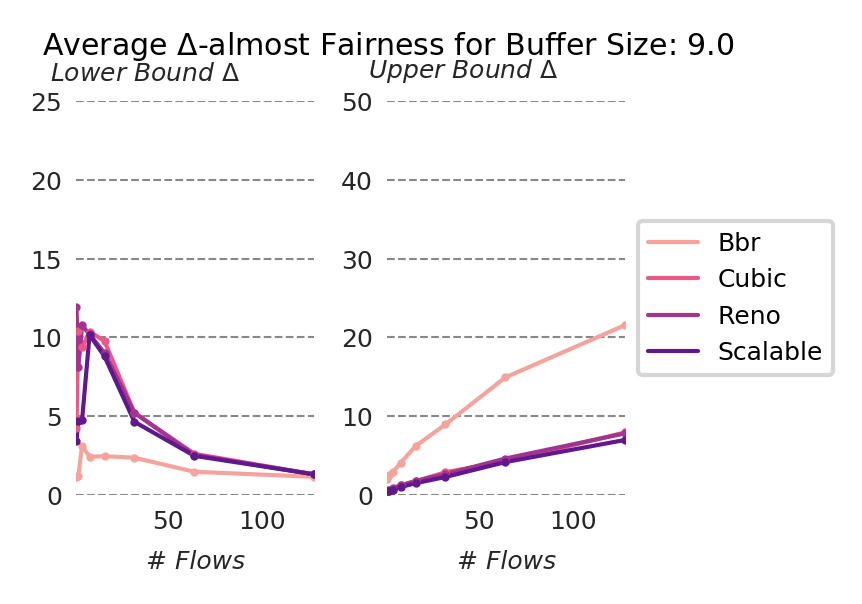

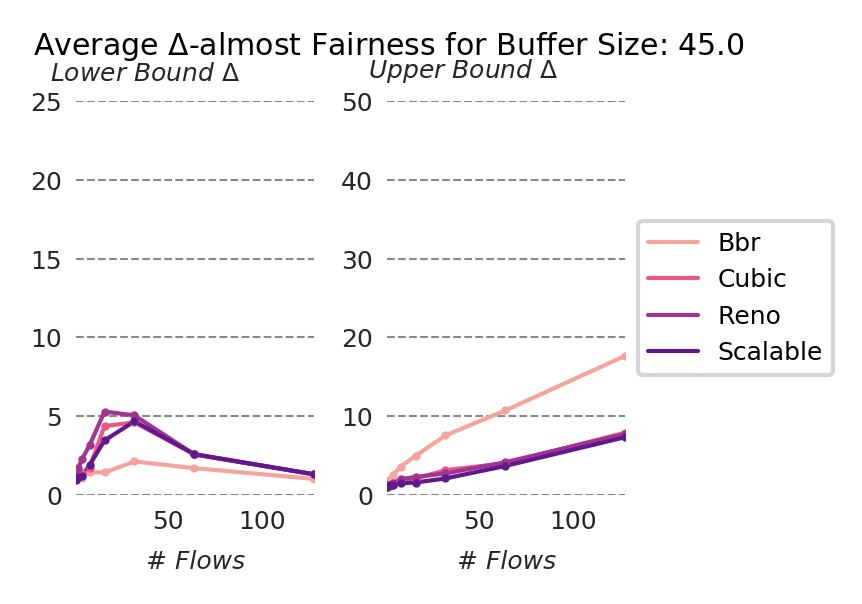

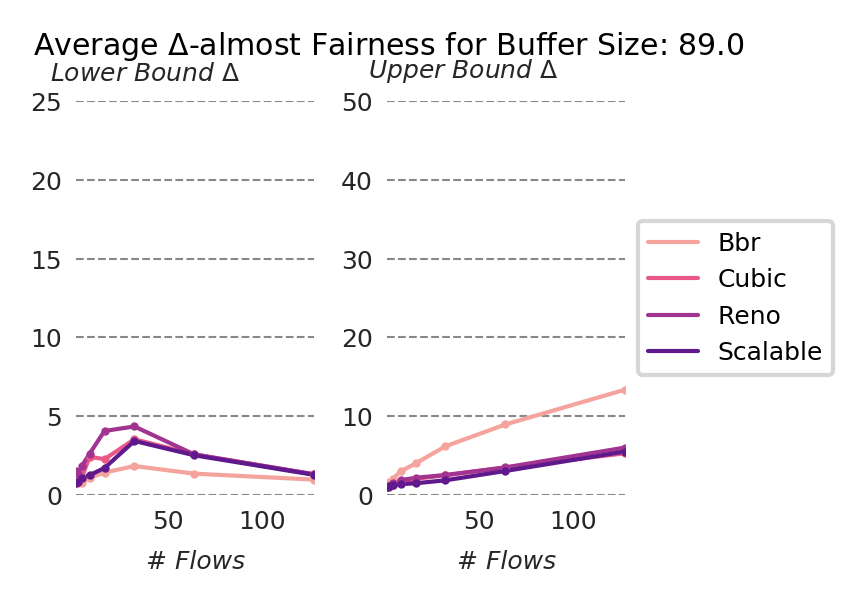

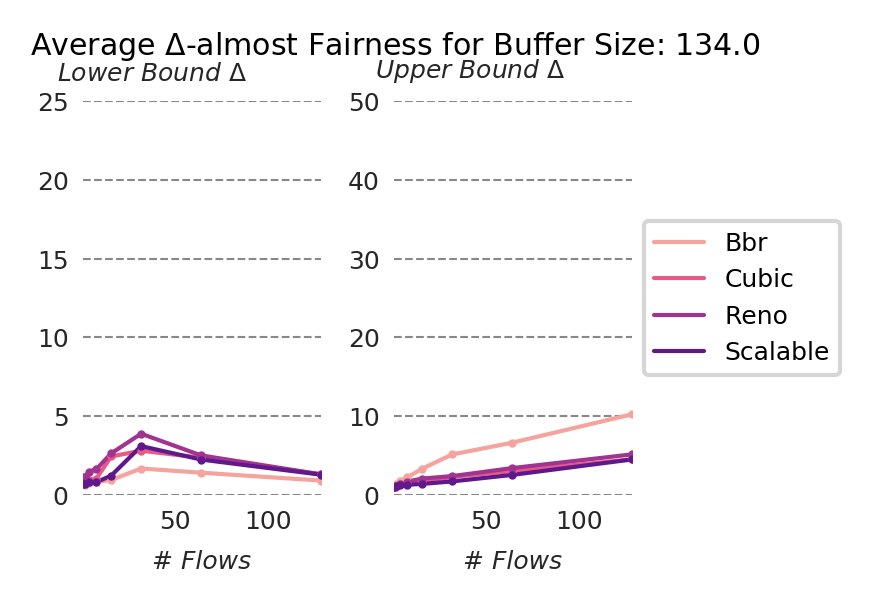

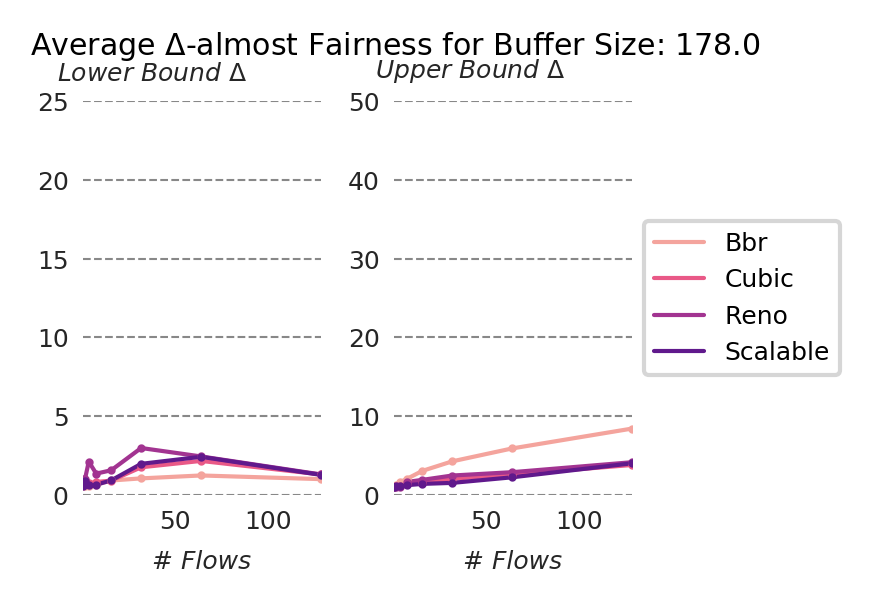

In [13]:
for buff_size, buf_df in deltas_df.groupby(['buff_size']):
    if len(pd.unique(buf_df.algorithm)) == 1:
        continue
    
    plt.figure(figsize=(width, width*2/3))
    
    plt.subplot(1,2,1)
    plorts.plot(data=buf_df, x='num_flows', y='ave_delta_l', hue='algorithm')
    plorts.scatter(data=buf_df, x='num_flows', y='ave_delta_l', hue='algorithm', markersize=1)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel(r"Lower Bound $\Delta$")
    plt.xlabel("# Flows")
    plt.axis(ymin=0,ymax=25)
    plorts.style_axis()
    
    plt.subplot(1,2,2)
    plorts.plot(data=buf_df, x='num_flows', y='ave_delta_r', hue='algorithm')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plorts.scatter(data=buf_df, x='num_flows', y='ave_delta_r', hue='algorithm', markersize=1)
    plt.ylabel(r"Upper Bound $\Delta$")
    plt.xlabel("# Flows")
    plt.axis(ymin=0,ymax=50)
    plorts.style_axis()
    
    plt.suptitle(r"Average $\Delta$-almost Fairness for Buffer Size: {}".format(buff_size),
                 x = 0.45, y = 1)
    
    plt.savefig('../figures/delta_almost_fairness/averageFairness_bufferSize_{}.jpg'.format(buff_size))
    plt.show()

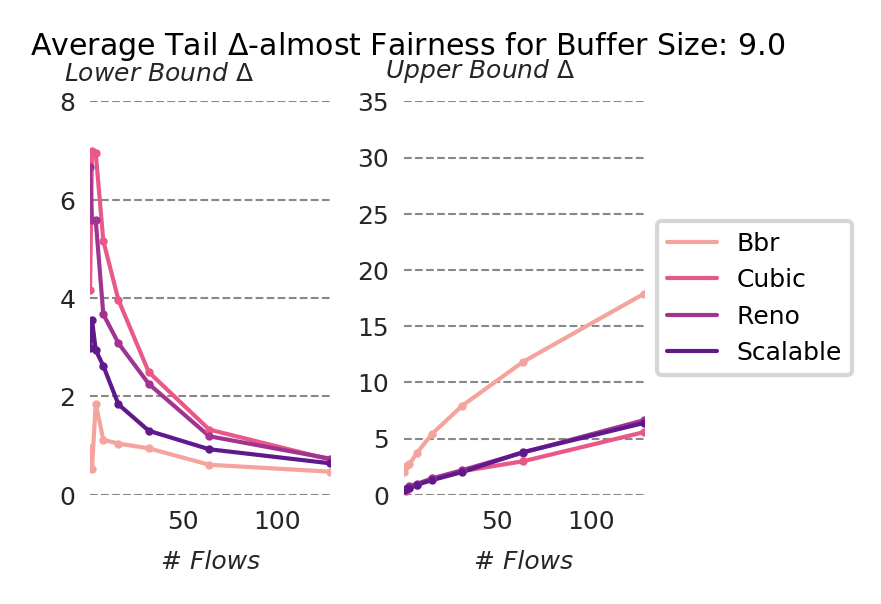

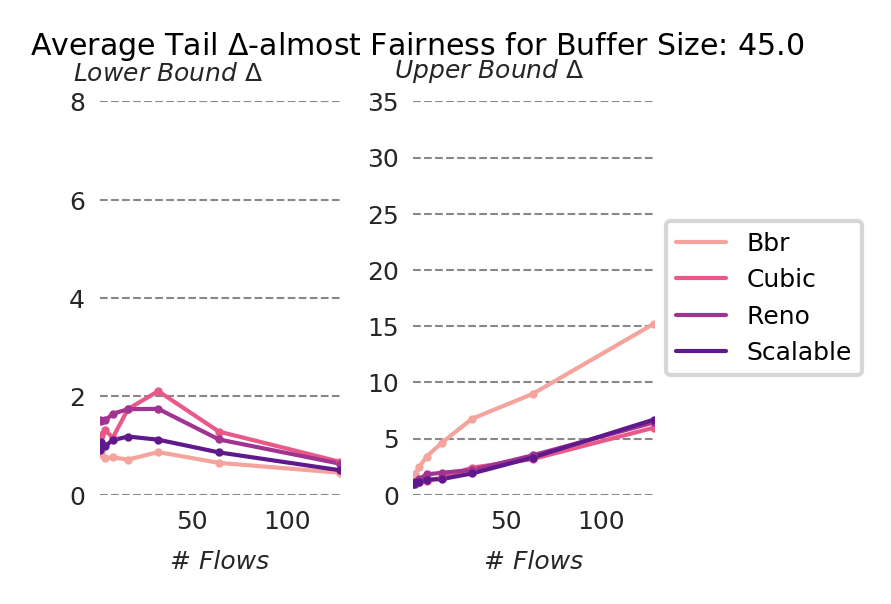

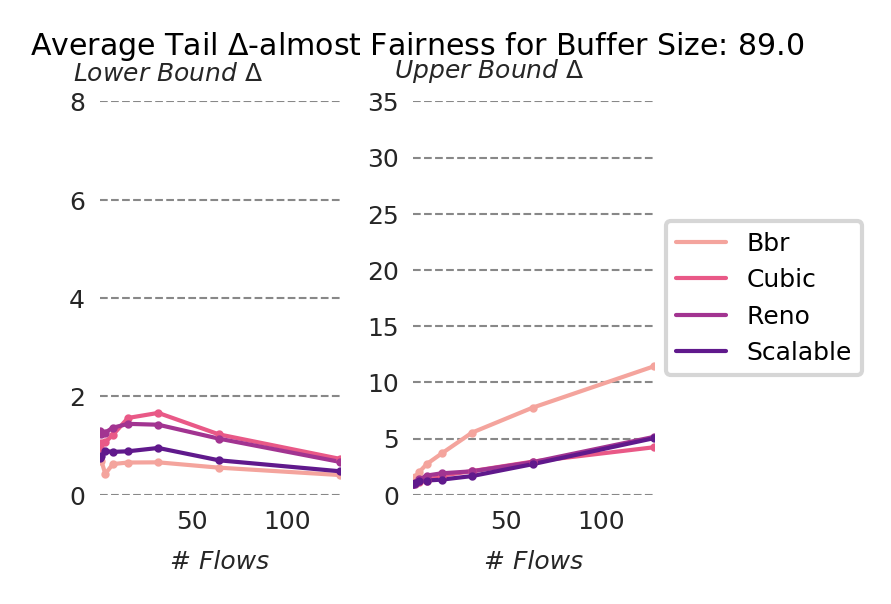

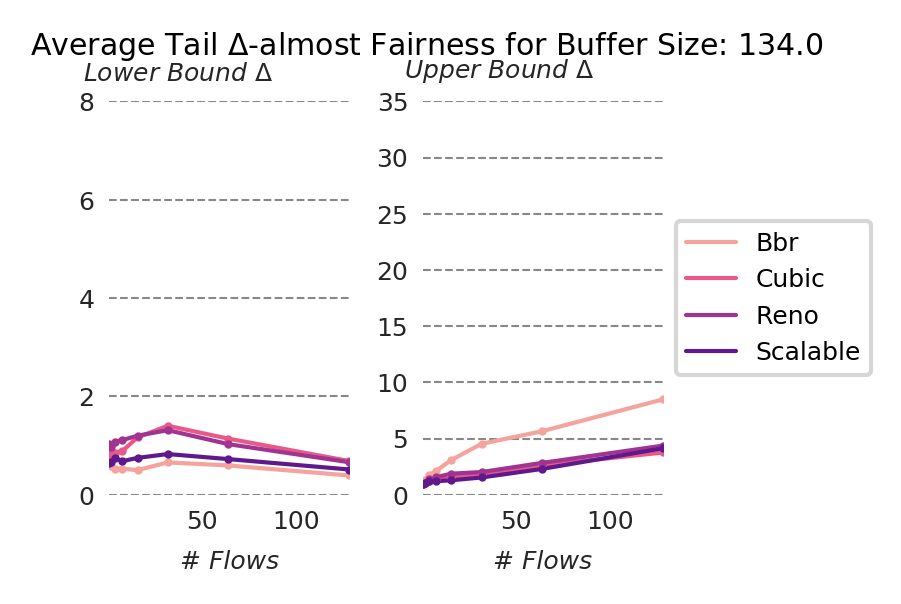

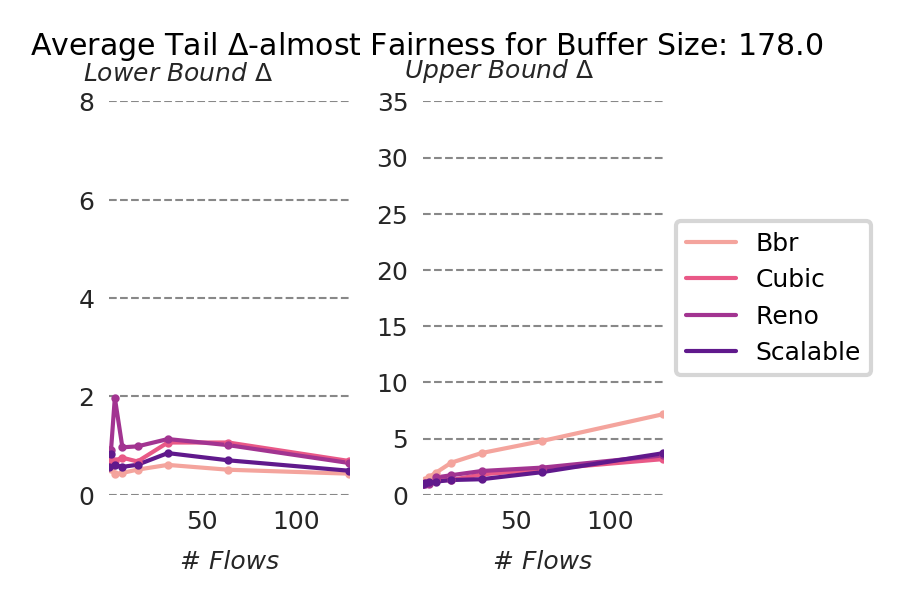

In [16]:
for buff_size, buf_df in deltas_df.groupby(['buff_size']):
    if len(pd.unique(buf_df.algorithm)) == 1:
        continue
    
    plt.figure(figsize=(width, width*2/3))
    
    plt.subplot(1,2,1)
    plorts.plot(data=buf_df, x='num_flows', y='ave_delta_l_tail', hue='algorithm')
    plorts.scatter(data=buf_df, x='num_flows', y='ave_delta_l_tail', hue='algorithm', markersize=1)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel(r"Lower Bound $\Delta$")
    plt.xlabel("# Flows")
    plt.axis(ymin=0,ymax=8)
    plorts.style_axis()
    
    plt.subplot(1,2,2)
    plorts.plot(data=buf_df, x='num_flows', y='ave_delta_r_tail', hue='algorithm')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plorts.scatter(data=buf_df, x='num_flows', y='ave_delta_r_tail', hue='algorithm', markersize=1)
    plt.ylabel(r"Upper Bound $\Delta$")
    plt.xlabel("# Flows")
    plt.axis(ymin=0,ymax=35)
    plorts.style_axis()
    
    plt.suptitle(r"Average Tail $\Delta$-almost Fairness for Buffer Size: {}".format(buff_size),
                 x = 0.45, y = 1)
    
    plt.savefig('../figures/delta_almost_fairness/averageFairness_tail_bufferSize_{}.jpg'.format(buff_size))
    plt.show()